In [1]:
import torch
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch import nn
import torch.nn.functional as F

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

val_data, test_data = torch.utils.data.random_split(test_data, [int(0.9 * len(test_data)), int(0.1 * len(test_data))])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



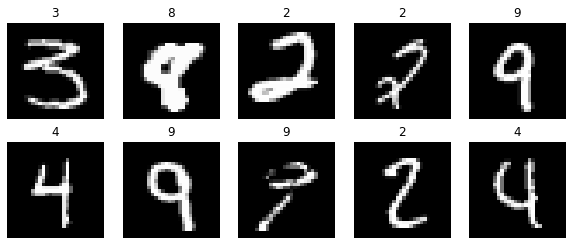

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

figure = plt.figure(figsize=(10, 4))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=200, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=False, 
                                          num_workers=1),
           
    'validate' : torch.utils.data.DataLoader(val_data, 
                                          batch_size=100, 
                                          shuffle=False, 
                                          num_workers=1)
}

In [5]:
class vanilla_RNN(nn.Module):
    def __init__(self):
        
        super().__init__()

        self.rnn = nn.RNN(input_size = 28, 
                          hidden_size = 128, 
                          num_layers = 1,
                          bidirectional = False, 
                          batch_first = True)       
        self.fc = nn.Linear(128, 10)
        
    def forward(self, x):

        output, hidden = self.rnn(x)
        out = self.fc(output[:,-1,:]) 
           
        return out

In [6]:
class vanilla_LSTM(nn.Module):
    
    def __init__(self):
        super(vanilla_LSTM, self).__init__()
        self.hidden_size = 128
        self.num_layers = 1
        self.lstm = nn.LSTM(input_size = 28, hidden_size = 128, num_layers = 1, batch_first=True)
        self.fc = nn.Linear(128, 10)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Passing in the input and hidden state into the model and  obtaining outputs
        out, hidden = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

In [7]:
class vanilla_GRU(nn.Module):
    
    def __init__(self): #class constructor with params for hidden layer and input size
        super(vanilla_GRU, self).__init__() #calls the parent constructor
        
        #configuring the RNN
        self.gru = nn.GRU(input_size = 28, 
                          hidden_size = 128, 
                          num_layers = 1,
                          batch_first = True)
        
        #we want to use the output of the Hidden Layer for the next time step
        self.fc = nn.Linear(128,10) #as size of the output is 10        
    
    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
        
        h_0 = torch.zeros(1, x.size(0), 128).to(device)
        out, h_n = self.gru(x, (h_0))

        #we want the output at the last time step alone
        out = self.fc(out[:,-1,:]) #obtain the output of the last hidden state
        return out

In [8]:
class bidirectional_RNN(nn.Module):
    def __init__(self):
        
        super().__init__()

        self.rnn = nn.RNN(input_size = 28, 
                          hidden_size = 128, 
                          num_layers = 2,
                          bidirectional = True, 
                          batch_first = True)       
        self.fc = nn.Linear(128*2, 10)
        
    def forward(self, x):

        output, hidden = self.rnn(x)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        out = self.fc(hidden) 
           
        return out

In [9]:
class bidirectional_LSTM(nn.Module):

    def __init__(self):
        super(bidirectional_LSTM, self).__init__()
        self.input_dim = 28
        self.hidden_dim = 128
        self.batch_size = 100
        self.num_layers = 2

        #Define the initial linear hidden layer
        self.init_linear = nn.Linear(self.input_dim, self.input_dim)

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True, bidirectional=True)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim * 2, 10)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        #Forward pass through initial hidden layer
        linear_input = self.init_linear(input)
        # Forward pass through LSTM layer
        # shape of lstm_out: [batch_size, input_size ,hidden_dim]
        # shape of self.hidden: (a, b), where a and b both
        # have shape (batch_size, num_layers, hidden_dim).
        out, self.hidden = self.lstm(linear_input)

        y_pred = self.linear(out[:, -1, :])
        return y_pred


In [10]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 20
learning_rate = 0.001

In [11]:
from torch import optim
loss_func = nn.CrossEntropyLoss()

In [12]:
def train(no_epochs, model, loaders):
    train_loss = list()
    val_loss = list()
    pred_accuracy = list()
    best_val_loss = 1
    for epoch in range(no_epochs):
        total_train_loss = 0
        total_val_loss = 0

        model.train()
        # training
        for itr, (images, labels) in enumerate(loaders['train']):
            
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        total_train_loss = total_train_loss / (itr + 1)
        train_loss.append(total_train_loss)
        
        # validation
        model.eval()
        total = 0
        for itr, (images, labels) in enumerate(loaders['validate']):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)

            loss = loss_func(outputs, labels)
            total_val_loss += loss.item()

            pred = torch.nn.functional.softmax(outputs, dim=1)
            for i, p in enumerate(pred):
                if labels[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

        accuracy = total / len(val_data)
        pred_accuracy.append(accuracy)

        total_val_loss = total_val_loss / (itr + 1)
        val_loss.append(total_val_loss)

        print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
            model_state = model.state_dict()

    fig=plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
    plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Loss Plot")
    plt.legend(loc='upper right')

    plt.subplot(1,2,2)
    plt.plot(np.arange(1, no_epochs+1), pred_accuracy, label="Prediction accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy plot")
    plt.legend(loc='lower right')
    return model_state

In [13]:
def evaluate(model, loaders):

    model.eval()
    total_test_loss = 0
    total = 0
    
    with torch.no_grad():

        for itr, (images, labels) in enumerate(loaders['test']):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)

            loss = loss_func(outputs, labels)
            total_test_loss += loss.item()

            pred = torch.nn.functional.softmax(outputs, dim=1)
            for i, p in enumerate(pred):
                if labels[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

        accuracy = total / len(test_data)
        total_test_loss = total_test_loss / (itr + 1)
        
    return loss, accuracy


Epoch: 1/20, Train Loss: 1.19888011, Val Loss: 0.86151552, Val Accuracy: 0.70722222
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.86151552

Epoch: 2/20, Train Loss: 0.77678100, Val Loss: 0.64806143, Val Accuracy: 0.78166667
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.64806143

Epoch: 3/20, Train Loss: 0.58852041, Val Loss: 0.56070454, Val Accuracy: 0.81633333
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.56070454

Epoch: 4/20, Train Loss: 0.42185558, Val Loss: 0.40363579, Val Accuracy: 0.87755556
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.40363579

Epoch: 5/20, Train Loss: 0.30709709, Val Loss: 0.30536199, Val Accuracy: 0.90977778
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.30536199

Epoch: 6/20, Train Loss: 0.25253339, Val Loss: 0.23174840, Val Accuracy: 0.93300000
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.23174840

Epoch: 7/

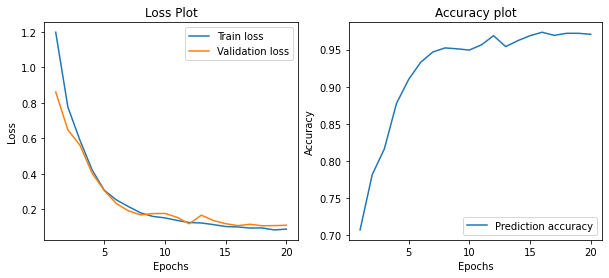

In [14]:
model = vanilla_RNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
model_state = train(num_epochs, model, loaders)
torch.save(model_state, 'vanilla_RNN_model.pt')
model.load_state_dict(torch.load('vanilla_RNN_model.pt'))

test_loss, test_acc = evaluate(model, loaders)

print('Vanilla RNN model results')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


Epoch: 1/20, Train Loss: 0.93903679, Val Loss: 0.40519019, Val Accuracy: 0.87766667
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.40519019

Epoch: 2/20, Train Loss: 0.30917939, Val Loss: 0.22008655, Val Accuracy: 0.93477778
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.22008655

Epoch: 3/20, Train Loss: 0.19727633, Val Loss: 0.15886498, Val Accuracy: 0.95311111
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.15886498

Epoch: 4/20, Train Loss: 0.14469027, Val Loss: 0.12606235, Val Accuracy: 0.96311111
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.12606235

Epoch: 5/20, Train Loss: 0.11062843, Val Loss: 0.09818022, Val Accuracy: 0.97200000
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.09818022

Epoch: 6/20, Train Loss: 0.08823677, Val Loss: 0.08668148, Val Accuracy: 0.97433333
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.08668148

Epoch: 7/

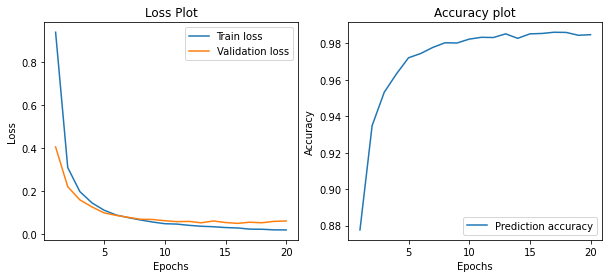

In [15]:
model = vanilla_GRU().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
model_state = train(num_epochs, model, loaders)
torch.save(model_state, 'vanilla_GRU_model.pt')
model.load_state_dict(torch.load('vanilla_GRU_model.pt'))

test_loss, test_acc = evaluate(model, loaders)

print('Vanilla GRU model results')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


Epoch: 1/20, Train Loss: 0.78090751, Val Loss: 0.28406395, Val Accuracy: 0.91777778
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.28406395

Epoch: 2/20, Train Loss: 0.21644092, Val Loss: 0.16410900, Val Accuracy: 0.95277778
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.16410900

Epoch: 3/20, Train Loss: 0.14404217, Val Loss: 0.12017448, Val Accuracy: 0.96433333
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.12017448

Epoch: 4/20, Train Loss: 0.11059395, Val Loss: 0.10406771, Val Accuracy: 0.96811111
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.10406771

Epoch: 5/20, Train Loss: 0.08863590, Val Loss: 0.08701664, Val Accuracy: 0.97388889
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.08701664

Epoch: 6/20, Train Loss: 0.07767440, Val Loss: 0.09385216, Val Accuracy: 0.97166667

Epoch: 7/20, Train Loss: 0.06441364, Val Loss: 0.07665028, Val Accuracy: 0.97755556
Savin

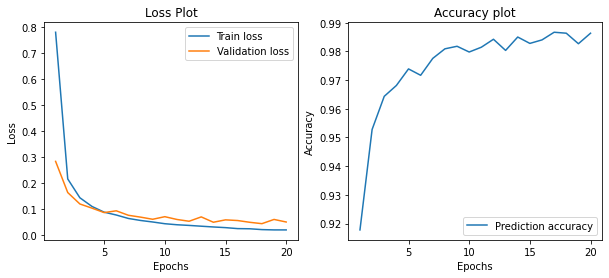

In [16]:
model = vanilla_LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
model_state = train(num_epochs, model, loaders)
torch.save(model_state, 'vanilla_LSTM_model.pt')
model.load_state_dict(torch.load('vanilla_LSTM_model.pt'))

test_loss, test_acc = evaluate(model, loaders)

print('Vanilla LSTM model results')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


Epoch: 1/20, Train Loss: 0.59683248, Val Loss: 0.29524118, Val Accuracy: 0.90866667
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.29524118

Epoch: 2/20, Train Loss: 0.21784056, Val Loss: 0.19295015, Val Accuracy: 0.94088889
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.19295015

Epoch: 3/20, Train Loss: 0.15146578, Val Loss: 0.11665084, Val Accuracy: 0.96577778
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.11665084

Epoch: 4/20, Train Loss: 0.11635646, Val Loss: 0.09193899, Val Accuracy: 0.97400000
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.09193899

Epoch: 5/20, Train Loss: 0.10536336, Val Loss: 0.11026059, Val Accuracy: 0.96444444

Epoch: 6/20, Train Loss: 0.09342759, Val Loss: 0.08880541, Val Accuracy: 0.97400000
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.08880541

Epoch: 7/20, Train Loss: 0.08915616, Val Loss: 0.07583316, Val Accuracy: 0.97655556
Savin

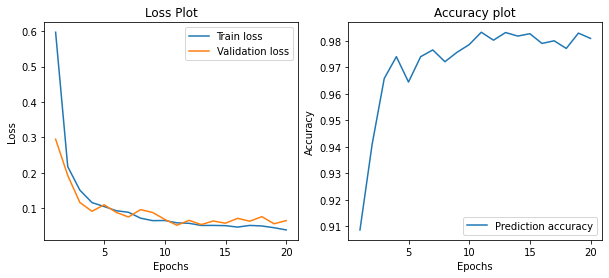

In [17]:
model = bidirectional_RNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
model_state = train(num_epochs, model, loaders)
torch.save(model_state, 'bidirectional_RNN.pt')
model.load_state_dict(torch.load('bidirectional_RNN.pt'))

test_loss, test_acc = evaluate(model, loaders)

print('Bidirectional RNN model results')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


Epoch: 1/20, Train Loss: 0.67779938, Val Loss: 0.20999537, Val Accuracy: 0.93900000
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.20999537

Epoch: 2/20, Train Loss: 0.14667945, Val Loss: 0.11287760, Val Accuracy: 0.96622222
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.11287760

Epoch: 3/20, Train Loss: 0.09533961, Val Loss: 0.08783003, Val Accuracy: 0.97266667
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.08783003

Epoch: 4/20, Train Loss: 0.06926476, Val Loss: 0.07495952, Val Accuracy: 0.97911111
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.07495952

Epoch: 5/20, Train Loss: 0.05660586, Val Loss: 0.05680364, Val Accuracy: 0.98322222
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.05680364

Epoch: 6/20, Train Loss: 0.04325891, Val Loss: 0.04838364, Val Accuracy: 0.98577778
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.04838364

Epoch: 7/

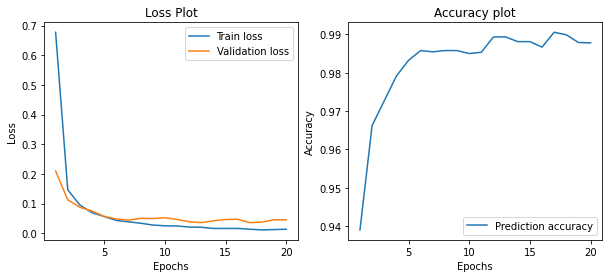

In [18]:
model = bidirectional_LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
model_state = train(num_epochs, model, loaders)
torch.save(model_state, 'bidirectional_LSTM.pt')
model.load_state_dict(torch.load('bidirectional_LSTM.pt'))

test_loss, test_acc = evaluate(model, loaders)

print('Bidirectional LSTM model results')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [20]:
for itr, (images, labels) in enumerate(loaders['test']):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        #pred = model(images)
        pred = torch.nn.functional.softmax(outputs, dim=1)
        pred_label = np.zeros((100,1))
        for i, p in enumerate(pred):
            pred_label[i] = int(torch.max(p.data, 0)[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


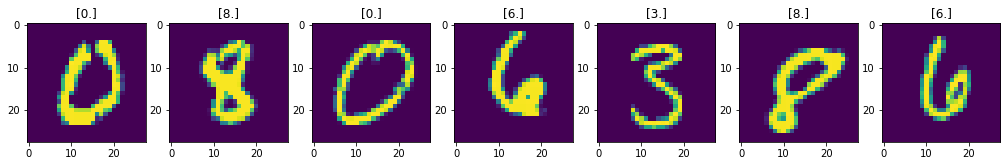

In [21]:
fig=plt.figure(figsize=(20, 10))
for test_images, test_labels in loaders['test']:  
    for i in range(1,8):
        sample_image = test_images[i]
        sample_label = pred_label[i]
        img = transforms.ToPILImage(mode='L')(sample_image)
        fig.add_subplot(1, 8, i)
        plt.title(str(sample_label))
        plt.imshow(img)
plt.show()